In [ ]:
#%%

import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()

from zipline.api          import (
    set_commission, 
    set_slippage,
    symbol, 
    symbols, 
    schedule_function, 
    order_target_percent,
)
from zipline.finance      import slippage   as slippage_lib
from zipline.finance      import commission as commission_lib
from zipline.utils.events import date_rules, time_rules
from zipline              import run_algorithm
from datetime             import datetime
import pandas             as pd
import numpy              as np
import quantstats         as qs
import matplotlib.pyplot  as plt
import riskfolio          as rp

In [ ]:
#%%

class CustomCostModel(commission_lib.CommissionModel):
    def __init__(self, buy_cost, sell_cost):
        self.buy_cost  = buy_cost
        self.sell_cost = sell_cost
    def calculate(self, order, transaction):
        if transaction.amount > 0:
            cost = self.buy_cost
        else:
            cost = self.sell_cost
        return abs(transaction.amount)*cost


def initialize(context):
    context.assets = symbols(
        'JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 
        'JPM', 'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 
        'PCAR', 'TXT', 'TMO', 'DE', 'MSFT', 'HPQ', 
        'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA'
    )
    context.dataset_start = None
    set_slippage(slippage_lib.FixedSlippage(spread=0.0011))
    set_commission(CustomCostModel(buy_cost=0.0036, sell_cost=0.0081))
    schedule_function(rebalance, date_rules.week_start(), time_rules.market_open())

    context.optimization_months = 24
    context.optimization_window = pd.Timedelta(days=context.optimization_months * 30)
    context.dataset_start = None


def rebalance(context, data):
    if context.dataset_start is None:
        context.dataset_start = data.current_dt

    group_start_date = data.current_dt
    if (group_start_date - context.dataset_start) < context.optimization_window:
        return

    optimization_prices_df  = data.history(context.assets, 'price', context.optimization_window.days, '1d')
    optimization_returns_df = optimization_prices_df.pct_change().dropna()

    portfolio_optimizer     = rp.Portfolio(returns=optimization_returns_df)
    portfolio_optimizer.assets_stats(method_mu='hist', method_cov='hist', d=0.94)
    optimized_w = portfolio_optimizer.rp_optimization(
        model = 'Classic',
        rm    = 'MV',
        hist  = True,
        rf    = 0.05,
        b     = None
    )
    allocated_weights = optimized_w['weights']
    for asset in context.assets:
        weight = allocated_weights[asset]
        order_target_percent(asset, weight)

    
def handle_data(context, data):
    pass

[2024-05-20 12:23:38.883030] INFO: Norgate Data: NorgateData package v1.0.74: Init complete
[2024-05-20 12:23:38.886067] INFO: Norgate Data: Zipline v3.0.4 detected
[2024-05-20 12:23:38.886067] INFO: Norgate Data: Zipline_norgatedata package v3.0.3: Init complete


<Axes: >

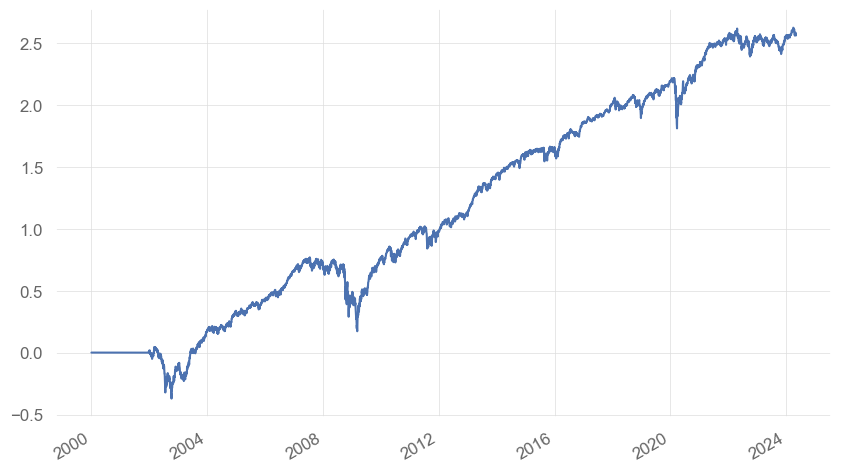

In [ ]:
#%%

start_date = pd.Timestamp('2000-01-01')
end_date   = pd.Timestamp('2024-05-01')

results = run_algorithm(
    start          = start_date,
    end            = end_date,
    initialize     = initialize,
    handle_data    = handle_data,
    capital_base   = 10000,
    data_frequency = 'daily',
    bundle         = 'norgatedata-sp500' # 'quandl'
)

results['returns'].cumsum().plot()

                    Strategy
------------------  ----------
Start Period        2000-01-03
End Period          2024-05-01
Risk-Free Rate      0.0%
Time in Market      92.0%

Cumulative Return   805.43%
CAGR﹪              6.45%

Sharpe              0.62
Prob. Sharpe Ratio  99.87%
Sortino             0.87
Sortino/√2          0.62
Omega               1.13

Max Drawdown        -49.85%
Longest DD Days     1201

Gain/Pain Ratio     0.13
Gain/Pain (1M)      0.82

Payoff Ratio        0.96
Profit Factor       1.13
Common Sense Ratio  1.08
CPC Index           0.59
Tail Ratio          0.96
Outlier Win Ratio   4.49
Outlier Loss Ratio  4.12

MTD                 -0.14%
3M                  0.49%
6M                  13.76%
YTD                 0.6%
1Y                  1.41%
3Y (ann.)           1.04%
5Y (ann.)           6.14%
10Y (ann.)          6.66%
All-time (ann.)     6.45%

Avg. Drawdown       -1.99%
Avg. Drawdown Days  24
Recovery Factor     5.13
Ulcer Index         0.1
Serenity Index      1.48


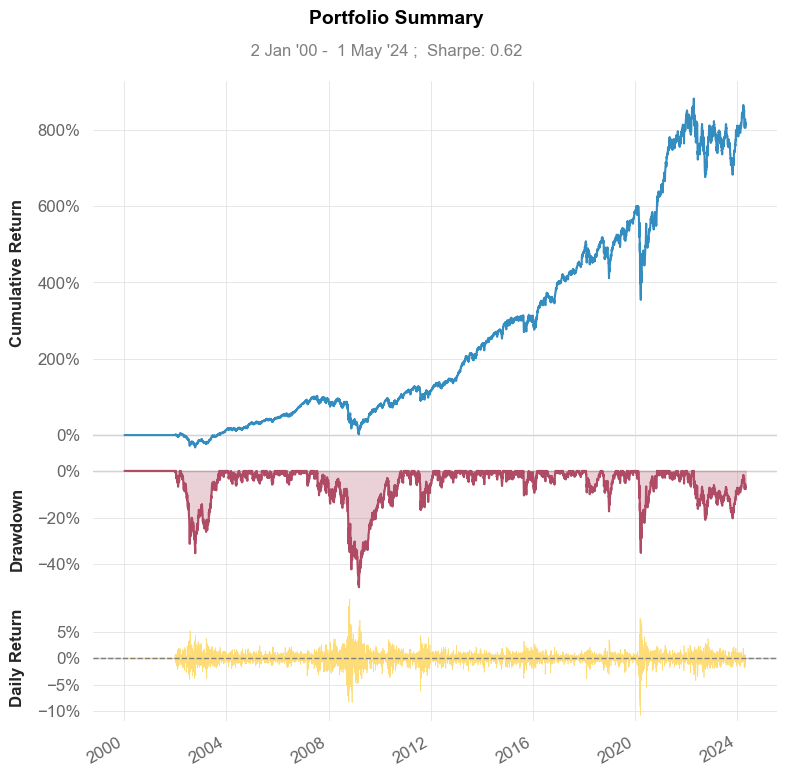

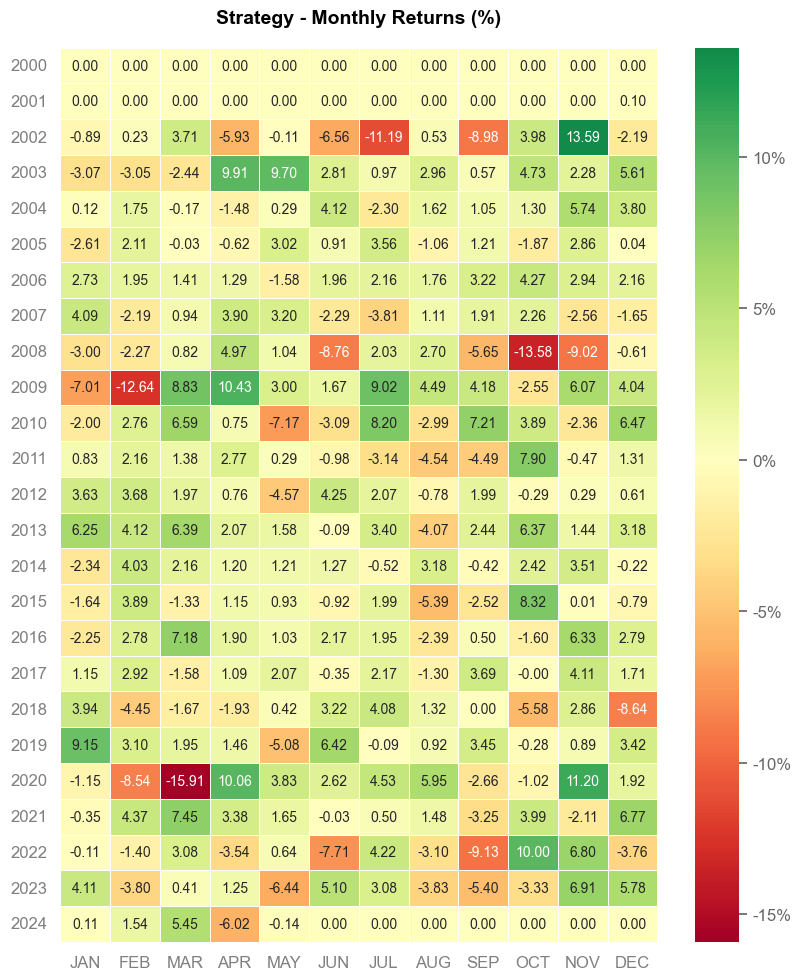

In [ ]:
#%%

qs.reports.basic(results['returns'])

In [ ]:
#%%

results

,period_open,period_close,long_value,longs_count,returns,starting_value,capital_used,pnl,transactions,starting_exposure,...,max_drawdown,alpha,beta,trading_days,excess_return,algo_volatility,max_leverage,benchmark_period_return,benchmark_volatility,period_label
2000-01-03 21:00:00+00:00,2000-01-03 14:31:00+00:00,2000-01-03 21:00:00+00:00,0.000,0,0.000000,0.000,0.00000,0.00000,[],0.000,...,0.0000,None,None,1,0.0,NaN,0.000000,0.0,NaN,2000-01
2000-01-04 21:00:00+00:00,2000-01-04 14:31:00+00:00,2000-01-04 21:00:00+00:00,0.000,0,0.000000,0.000,0.00000,0.00000,[],0.000,...,0.0000,None,None,2,0.0,0.000000,0.000000,0.0,0.0,2000-01
2000-01-05 21:00:00+00:00,2000-01-05 14:31:00+00:00,2000-01-05 21:00:00+00:00,0.000,0,0.000000,0.000,0.00000,0.00000,[],0.000,...,0.0000,None,None,3,0.0,0.000000,0.000000,0.0,0.0,2000-01
2000-01-06 21:00:00+00:00,2000-01-06 14:31:00+00:00,2000-01-06 21:00:00+00:00,0.000,0,0.000000,0.000,0.00000,0.00000,[],0.000,...,0.0000,None,None,4,0.0,0.000000,0.000000,0.0,0.0,2000-01
2000-01-07 21:00:00+00:00,2000-01-07 14:31:00+00:00,2000-01-07 21:00:00+00:00,0.000,0,0.000000,0.000,0.00000,0.00000,[],0.000,...,0.0000,None,None,5,0.0,0.000000,0.000000,0.0,0.0,2000-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-25 20:00:00+00:00,2024-04-25 13:31:00+00:00,2024-04-25 20:00:00+00:00,91000.671,25,-0.016404,92521.390,0.00000,-1520.71900,[],92521.390,...,-0.4985,None,None,6117,0.0,0.171090,1.013926,0.0,0.0,2024-04
2024-04-26 20:00:00+00:00,2024-04-26 13:31:00+00:00,2024-04-26 20:00:00+00:00,91073.871,25,0.000803,91000.671,0.00000,73.20000,[],91000.671,...,-0.4985,None,None,6118,0.0,0.171076,1.013926,0.0,0.0,2024-04
2024-04-29 20:00:00+00:00,2024-04-29 13:31:00+00:00,2024-04-29 20:00:00+00:00,91671.182,25,0.006545,91073.871,0.00000,597.31100,[],91073.871,...,-0.4985,None,None,6119,0.0,0.171066,1.013926,0.0,0.0,2024-04
2024-04-30 20:00:00+00:00,2024-04-30 13:31:00+00:00,2024-04-30 20:00:00+00:00,90790.566,25,-0.012913,91671.182,-305.45615,-1186.07215,"[{'amount': 2, 'dt': 2024-04-30 20:00:00+00:00...",91671.182,...,-0.4985,None,None,6120,0.0,0.171074,1.013926,0.0,0.0,2024-04
